<a href="https://colab.research.google.com/github/LatiefDataVisionary/deep-learning-college-task/blob/main/tasks/week_5_tasks/Task_ViT_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Section 0: Initial Setup (Pengaturan Awal)**

**Penjelasan:** Menginstal dan menyiapkan semua dependencies krusial dari ekosistem Hugging Face yang tidak terinstal secara default di Colab.

### **0.1. Install Core Libraries (Instalasi Library Inti)**

**Penjelasan:** Menginstal `transformers`, `datasets`, dan `accelerate` untuk memastikan kompatibilitas penuh dengan ekosistem Hugging Face.

In [1]:
# Install Hugging Face libraries
!pip install transformers datasets accelerate

### **0.2. Mount Google Drive (Menghubungkan Google Drive)**

**Penjelasan:** Menghubungkan notebook ini dengan akun Google Drive Anda. Ini diperlukan agar notebook dapat membaca file dataset gambar yang telah Anda simpan di Google Drive. Setelah menjalankan sel ini, ikuti instruksi otorisasi yang muncul.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Section 1: Import Libraries and Global Configuration (Impor Library dan Konfigurasi Global)**

**Penjelasan:** Mengimpor semua modul yang diperlukan dan mendefinisikan konstanta dan variabel konfigurasi yang akan digunakan di seluruh notebook.

### **1.1. Import Libraries (Impor Library)**

**Penjelasan:** Mengimpor library standar seperti tensorflow, numpy, matplotlib, os, zipfile, sklearn.metrics, serta library spesifik Hugging Face seperti datasets dan transformers.

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import glob # To list files
import shutil # To manage directories
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns # For confusion matrix visualization
import pandas as pd # For data manipulation and analysis
import random
from PIL import Image # Need PIL to open images for visualization

# Hugging Face Libraries
from datasets import load_dataset, DatasetDict
from transformers import AutoImageProcessor, TFAutoModelForImageClassification

### **1.2. Define Global Configurations (Definisi Konfigurasi Global)**

**Penjelasan:** Mendefinisikan variabel-variabel konfigurasi yang akan digunakan di seluruh notebook, termasuk path ke dataset, model checkpoint ViT, ukuran gambar, ukuran batch, dan jumlah epoch.

In [4]:
# Define Directory Paths (Definisi Path Direktori)
# Path ke file zip di Google Drive
ZIP_PATH = '/content/drive/MyDrive/Dataset/Dataset Sistem Presensi Wajah V1.0.zip'
# Path untuk mengekstrak dan menata ulang data agar sesuai format datasets.load_dataset('imagefolder')
EXTRACT_PATH = '/content/processed_dataset_hf' # Using a new path to avoid conflict with previous processed data

# Define Model and Training Parameters (Definisi Parameter Model dan Pelatihan)
MODEL_CHECKPOINT = "google/vit-base-patch16-224" # Pre-trained ViT model from Hugging Face
IMG_SIZE = 224 # Standard input size for this ViT model
BATCH_SIZE = 32
EPOCHS = 10 # Start with a smaller number of epochs for fine-tuning
# NUM_CLASSES will be determined by the dataset later
NUM_CLASSES = None # Placeholder

## **Section 2: Data Pipeline with Hugging Face datasets & Initial Data Inspection (Pipeline Data dengan datasets Hugging Face & Inspeksi Data Awal)**

**Penjelasan:** Bagian ini menangani ekstraksi data, menata ulang struktur folder agar kompatibel dengan library `datasets`, melakukan inspeksi awal terhadap distribusi kelas, memvisualisasikan sampel gambar, dan akhirnya memuat data menggunakan `datasets.load_dataset`.

### **2.1. Unzip and Structure Dataset (Ekstrak dan Strukturkan Dataset)**

**Penjelasan:** Kode untuk mengekstrak file .zip dan menata ulang gambar ke dalam struktur direktori yang dibutuhkan oleh `datasets.load_dataset('imagefolder')`. Struktur ini adalah `train/` dan `test/`, dengan sub-folder per kelas (NIM) di dalamnya. File gambar dengan ekstensi .jpg, .jpeg, dan .png akan disertakan.

In [5]:
# Remove existing extracted directory if it exists to start fresh
if os.path.exists(EXTRACT_PATH):
    print(f"Removing existing extracted directory: {EXTRACT_PATH}")
    shutil.rmtree(EXTRACT_PATH)

# Create the main extraction directory
os.makedirs(EXTRACT_PATH, exist_ok=True)

print(f"Extracting {ZIP_PATH} to temporary location...")
temp_raw_path = '/content/temp_raw_extraction'
if os.path.exists(temp_raw_path):
     shutil.rmtree(temp_raw_path)
os.makedirs(temp_raw_path, exist_ok=True)

try:
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(temp_raw_path)
    print("Extraction to temporary location complete.")
except FileNotFoundError:
    print(f"Error: Zip file not found at {ZIP_PATH}")
    # Exit or handle error appropriately if zip not found
    raise
except zipfile.BadZipFile:
    print(f"Error: Could not open or read zip file at {ZIP_PATH}. It might be corrupted.")
    # Exit or handle error appropriately
    raise
except Exception as e:
    print(f"An error occurred during extraction: {e}")
    raise

Removing existing extracted directory: /content/processed_dataset_hf
Extracting /content/drive/MyDrive/Dataset/Dataset Sistem Presensi Wajah V1.0.zip to temporary location...
Extraction to temporary location complete.


In [6]:
# Find the actual folder containing 'Data Train' and 'Data Test' inside the temporary extraction
raw_data_base_folder = None
for item in os.listdir(temp_raw_path):
    item_path = os.path.join(temp_raw_path, item)
    if os.path.isdir(item_path):
        # Check if it contains 'Data Train' or 'Data Test'
        if 'Data Train' in os.listdir(item_path) or 'Data Test' in os.listdir(item_path):
            raw_data_base_folder = item_path
            break

if not raw_data_base_folder:
    print(f"Error: Could not find 'Data Train' or 'Data Test' folders within the extracted data at {temp_raw_path}. Please check the zip file structure.")
    # Exit or handle error appropriately
    raise FileNotFoundError("Raw data structure not found")


raw_train_folder = os.path.join(raw_data_base_folder, 'Data Train')
raw_test_folder = os.path.join(raw_data_base_folder, 'Data Test')

In [7]:
# Create train and test directories in the final EXTRACT_PATH for datasets library
extracted_train_dir = os.path.join(EXTRACT_PATH, 'train')
extracted_test_dir = os.path.join(EXTRACT_PATH, 'test')

os.makedirs(extracted_train_dir, exist_ok=True)
os.makedirs(extracted_test_dir, exist_ok=True)

print(f"\nStructuring data for datasets.load_dataset('imagefolder')...")
print(f"Reading from: {raw_train_folder} and {raw_test_folder}")
print(f"Saving to: {extracted_train_dir} and {extracted_test_dir}")


Structuring data for datasets.load_dataset('imagefolder')...
Reading from: /content/temp_raw_extraction/Dataset Sistem Presensi Wajah V1.0/Data Train and /content/temp_raw_extraction/Dataset Sistem Presensi Wajah V1.0/Data Test
Saving to: /content/processed_dataset_hf/train and /content/processed_dataset_hf/test


In [8]:
# Function to copy and structure images
def copy_and_structure_images(source_dir, dest_dir):
    total_copied = 0
    skipped_short_filename = 0
    skipped_other_error = 0

    # Use glob to find files with multiple extensions
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        image_files.extend(glob.glob(os.path.join(source_dir, ext)))

    # print(f"Found {len(image_files)} images in {source_dir}") # Debug print

    for img_path in image_files:
        try:
            filename = os.path.basename(img_path)
            # Extract NIM (class name) from filename (first 10 characters)
            if len(filename) < 10:
                print(f"Warning: Filename {filename} is too short to extract NIM. Skipping.")
                skipped_short_filename += 1
                continue

            nim = filename[:10] # Assuming first 10 chars are NIM

            # Define destination directory (dest_dir/NIM/)
            dest_class_dir = os.path.join(dest_dir, nim)
            os.makedirs(dest_class_dir, exist_ok=True) # Ensure the class directory exists

            # Define final destination path
            dest_path = os.path.join(dest_class_dir, filename)

            # Copy the image file
            shutil.copy(img_path, dest_path)
            total_copied += 1

        except Exception as e:
            print(f"An error occurred while processing {img_path}: {e}")
            skipped_other_error += 1
            continue

    print(f"Finished structuring data from {source_dir}.")
    print(f"Total images copied: {total_copied}")
    print(f"Images skipped (short filename): {skipped_short_filename}")
    print(f"Images skipped (other error): {skipped_other_error}")
    return total_copied

In [9]:
# Run the structuring process for train and test data
train_copied_count = 0
test_copied_count = 0

if os.path.exists(raw_train_folder):
    print("\nProcessing training data...")
    train_copied_count = copy_and_structure_images(raw_train_folder, extracted_train_dir)
else:
    print(f"Warning: Raw train folder not found at {raw_train_folder}. Skipping train data structuring.")

if os.path.exists(raw_test_folder):
    print("\nProcessing testing data...")
    test_copied_count = copy_and_structure_images(raw_test_folder, extracted_test_dir)
else:
     print(f"Warning: Raw test folder not found at {raw_test_folder}. Skipping test data structuring.")


Processing training data...
Finished structuring data from /content/temp_raw_extraction/Dataset Sistem Presensi Wajah V1.0/Data Train.
Total images copied: 1696
Images skipped (short filename): 0
Images skipped (other error): 0

Processing testing data...
Finished structuring data from /content/temp_raw_extraction/Dataset Sistem Presensi Wajah V1.0/Data Test.
Total images copied: 424
Images skipped (short filename): 0
Images skipped (other error): 0


In [10]:
# Clean up temporary extraction directory
if os.path.exists(temp_raw_path):
    print(f"\nCleaning up temporary extraction directory: {temp_raw_path}")
    shutil.rmtree(temp_raw_path)

print("\nDataset structuring complete for Hugging Face datasets.")
print(f"Total images structured for train: {train_copied_count}")
print(f"Total images structured for test: {test_copied_count}")


Cleaning up temporary extraction directory: /content/temp_raw_extraction

Dataset structuring complete for Hugging Face datasets.
Total images structured for train: 1696
Total images structured for test: 424


### **2.2. Inspect Class Distribution (Inspeksi Distribusi Kelas)**

**Penjelasan:** Menghitung dan menampilkan jumlah gambar per kelas di direktori training dan testing yang sudah ditata ulang (`EXTRACT_PATH/train` dan `EXTRACT_PATH/test`). Ini penting untuk memahami keseimbangan dataset sebelum melatih model.

In [11]:
# Count images in the structured directories
# This counts files within each class subdirectory
def count_images_in_structured_dir(directory):
    class_counts = {}
    if not os.path.exists(directory):
        return class_counts
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            # Count files with supported extensions
            img_count = 0
            for ext in ['*.jpg', '*.jpeg', '*.png']:
                 img_count += len(glob.glob(os.path.join(class_path, ext)))
            class_counts[class_folder] = img_count
    return class_counts

structured_train_class_counts = count_images_in_structured_dir(extracted_train_dir)
structured_test_class_counts = count_images_in_structured_dir(extracted_test_dir)

total_structured_train = sum(structured_train_class_counts.values())
total_structured_test = sum(structured_test_class_counts.values())


print(f"Jumlah total gambar di Data Train (setelah ditata ulang): {total_structured_train}")
print(f"Jumlah total gambar di Data Test (setelah ditata ulang): {total_structured_test}")
print(f"\nJumlah kelas (mahasiswa) di Data Train (setelah ditata ulang): {len(structured_train_class_counts)}")
print(f"Jumlah kelas (mahasiswa) di Data Test (setelah ditata ulang): {len(structured_test_class_counts)}")

Jumlah total gambar di Data Train (setelah ditata ulang): 1696
Jumlah total gambar di Data Test (setelah ditata ulang): 424

Jumlah kelas (mahasiswa) di Data Train (setelah ditata ulang): 53
Jumlah kelas (mahasiswa) di Data Test (setelah ditata ulang): 53


In [12]:
# --- Menampilkan Tabel Distribusi Kelas ---

print("\nTabel Distribusi Jumlah Gambar per Kelas (Data Train Setelah Ditata Ulang):")
if structured_train_class_counts:
    train_counts_df = pd.DataFrame(list(structured_train_class_counts.items()), columns=['NIM (Kelas)', 'Jumlah Gambar'])
    train_counts_df = train_counts_df.sort_values(by='NIM (Kelas)').reset_index(drop=True)
    display(train_counts_df)
else:
    print("Tidak ada data kelas di Data Train setelah ditata ulang.")


print("\nTabel Distribusi Jumlah Gambar per Kelas (Data Test Setelah Ditata Ulang):")
if structured_test_class_counts:
    test_counts_df = pd.DataFrame(list(structured_test_class_counts.items()), columns=['NIM (Kelas)', 'Jumlah Gambar'])
    test_counts_df = test_counts_df.sort_values(by='NIM (Kelas)').reset_index(drop=True)
    display(test_counts_df)
else:
    print("Tidak ada data kelas di Data Test setelah ditata ulang.")


Tabel Distribusi Jumlah Gambar per Kelas (Data Train Setelah Ditata Ulang):


,NIM (Kelas),Jumlah Gambar
0,5221911012,32
1,5221911025,32
2,5231811002,32
3,5231811004,32
4,5231811005,32
5,5231811006,32
6,5231811007,32
7,5231811008,32
8,5231811009,32
9,5231811010,32



Tabel Distribusi Jumlah Gambar per Kelas (Data Test Setelah Ditata Ulang):


,NIM (Kelas),Jumlah Gambar
0,5221911012,8
1,5221911025,8
2,5231811002,8
3,5231811004,8
4,5231811005,8
5,5231811006,8
6,5231811007,8
7,5231811008,8
8,5231811009,8
9,5231811010,8


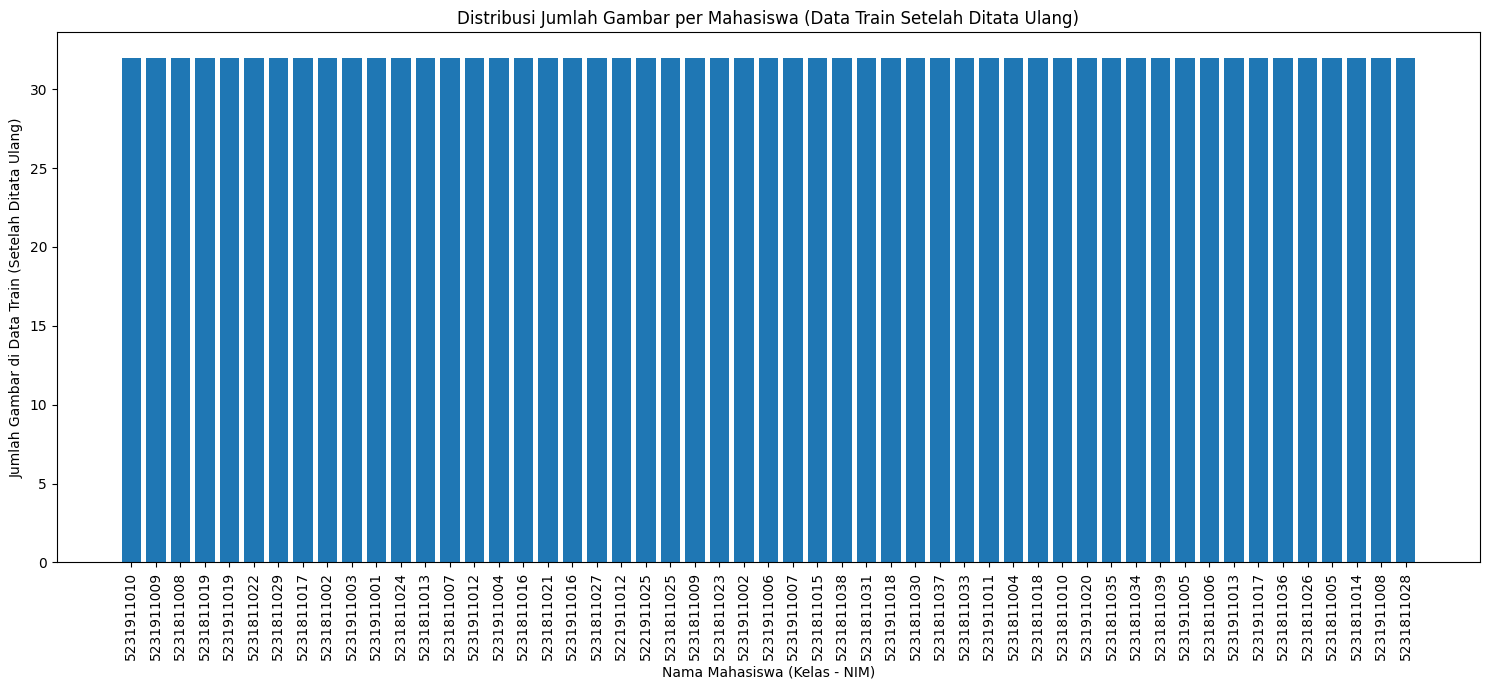

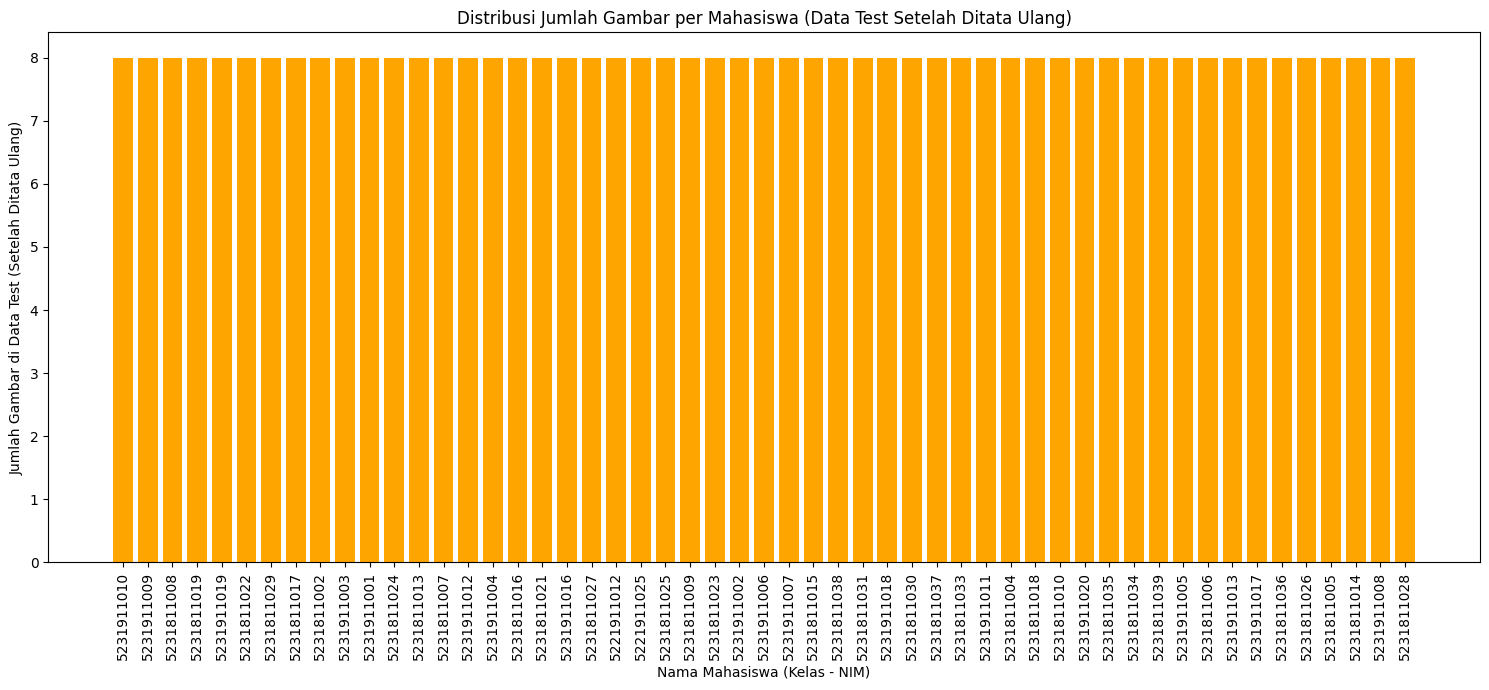

In [13]:
# --- Plot the distribution for Training data ---
if structured_train_class_counts:
    # Sort classes by count for better visualization (optional, but consistent with previous plot)
    sorted_structured_train_counts = dict(sorted(structured_train_class_counts.items(), key=lambda item: item[1]))

    plt.figure(figsize=(15, 7))
    plt.bar(sorted_structured_train_counts.keys(), sorted_structured_train_counts.values())
    plt.xticks(rotation=90)
    plt.xlabel("Nama Mahasiswa (Kelas - NIM)")
    plt.ylabel("Jumlah Gambar di Data Train (Setelah Ditata Ulang)")
    plt.title("Distribusi Jumlah Gambar per Mahasiswa (Data Train Setelah Ditata Ulang)")
    plt.tight_layout()
    plt.show()
else:
     print("\nTidak ada data kelas di Data Train untuk membuat plot distribusi.")

# --- Plot the distribution for Test data ---
if structured_test_class_counts:
    # Sort classes by count for better visualization
    sorted_structured_test_counts = dict(sorted(structured_test_class_counts.items(), key=lambda item: item[1]))

    plt.figure(figsize=(15, 7))
    plt.bar(sorted_structured_test_counts.keys(), sorted_structured_test_counts.values(), color='orange') # Use a different color
    plt.xticks(rotation=90)
    plt.xlabel("Nama Mahasiswa (Kelas - NIM)")
    plt.ylabel("Jumlah Gambar di Data Test (Setelah Ditata Ulang)")
    plt.title("Distribusi Jumlah Gambar per Mahasiswa (Data Test Setelah Ditata Ulang)")
    plt.tight_layout()
    plt.show()
else:
     print("\nTidak ada data kelas di Data Test untuk membuat plot distribusi.")

### **2.3. Visualize Sample Images (Visualisasi Sampel Gambar)**

**Penjelasan:** Menampilkan beberapa gambar acak dari direktori training yang sudah ditata ulang (`EXTRACT_PATH/train`) beserta label (NIM) mereka untuk melihat format gambar sebelum diproses oleh Hugging Face processor.

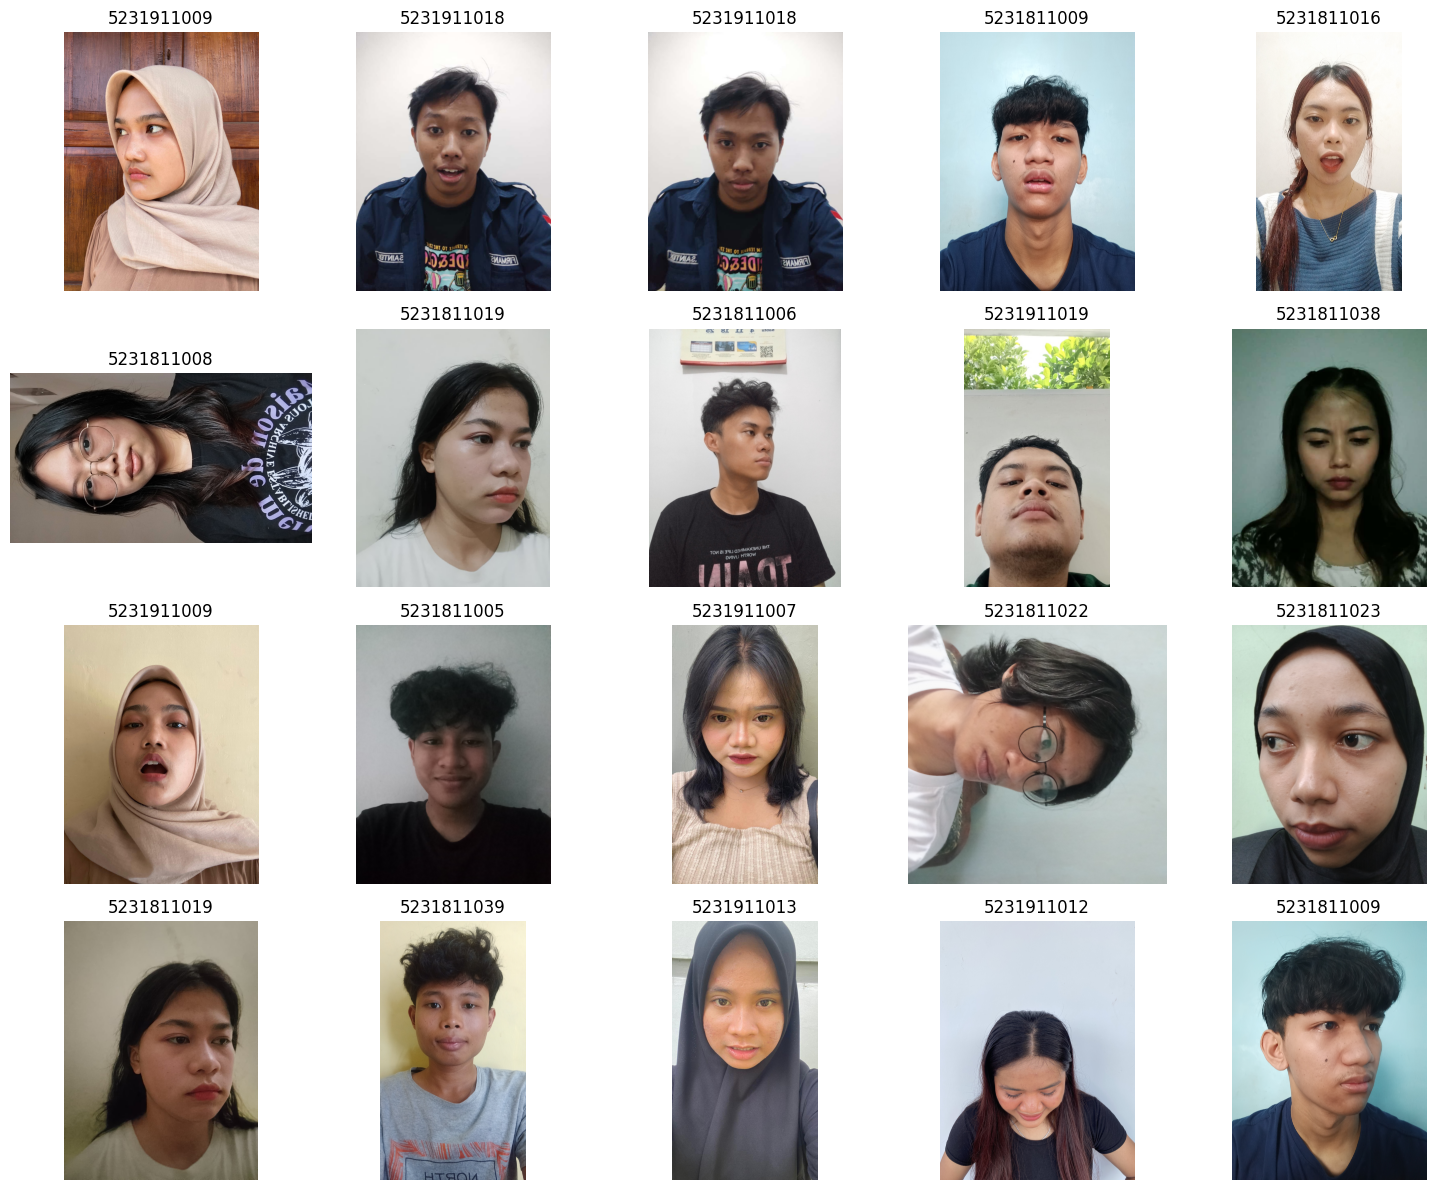

In [14]:
plt.figure(figsize=(15, 12)) # Adjust figure size

# Get a list of all class directories
class_dirs = [os.path.join(extracted_train_dir, d) for d in os.listdir(extracted_train_dir) if os.path.isdir(os.path.join(extracted_train_dir, d))]

all_structured_train_images = []
for class_dir in class_dirs:
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        all_structured_train_images.extend(glob.glob(os.path.join(class_dir, ext)))

# Check if there are enough images
num_samples_to_display = min(20, len(all_structured_train_images)) # Display up to 20 samples
if num_samples_to_display == 0:
    print("Tidak ada gambar di direktori training yang sudah ditata ulang untuk ditampilkan.")
else:
    # Select random images
    sample_images_paths = random.sample(all_structured_train_images, num_samples_to_display)

    for i, img_path in enumerate(sample_images_paths):
        plt.subplot(4, 5, i + 1) # Adjust subplot grid to 4 rows and 5 columns

        try:
            img = Image.open(img_path) # Use PIL to open image
            plt.imshow(img)

            # Extract class name (NIM) from directory name
            class_name = os.path.basename(os.path.dirname(img_path))

            plt.title(class_name)
            plt.axis("off")
        except Exception as e:
            print(f"Error loading or displaying image {img_path}: {e}")
            plt.title("Error")
            plt.axis("off")


    plt.tight_layout()
    plt.show()

### **2.4. Load Dataset with imagefolder (Memuat Dataset dengan imagefolder)**

**Penjelasan:** Menggunakan fungsi `load_dataset` dari library Hugging Face `datasets` dengan parameter `imagefolder` untuk secara otomatis memuat gambar dari struktur direktori yang sudah disiapkan (`EXTRACT_PATH`).

In [15]:
print(f"Loading dataset from {EXTRACT_PATH} using datasets.load_dataset('imagefolder')...")
try:
    # Use the EXTRACT_PATH which contains the 'train' and 'test' subdirectories
    dataset = load_dataset('imagefolder', data_dir=EXTRACT_PATH)
    print("Dataset loaded successfully.")
    print(dataset) # Display the DatasetDict structure
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")
    # Exit or handle error appropriately
    raise

Loading dataset from /content/processed_dataset_hf using datasets.load_dataset('imagefolder')...


Resolving data files:   0%|          | 0/1696 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/424 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset loaded successfully.
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1696
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 424
    })
})


### **2.5. Create Label Mappings (Membuat Pemetaan Label)**

**Penjelasan:** Mengekstrak nama-nama kelas (NIM) dari dataset yang dimuat oleh `datasets.load_dataset` dan membuat kamus (dictionary) untuk memetakan nama kelas ke ID integer (`label2id`) dan sebaliknya (`id2label`). Ini penting untuk konfigurasi model Transformer.

In [16]:
# The 'imagefolder' dataset automatically assigns integer labels.
# The class names (folder names) are available in dataset['train'].features['label'].names
labels = dataset['train'].features['label'].names

# Create label2id and id2label mappings
# Store ID as string if needed by model config, otherwise int is fine
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}


# Update NUM_CLASSES based on the loaded dataset
NUM_CLASSES = len(labels)

print(f"Identified {NUM_CLASSES} classes.")
print(f"label2id mapping example: {list(label2id.items())[:10]}...")
print(f"id2label mapping example: {list(id2label.items())[:10]}...")

Identified 53 classes.
label2id mapping example: [('5221911012', 0), ('5221911025', 1), ('5231811002', 2), ('5231811004', 3), ('5231811005', 4), ('5231811006', 5), ('5231811007', 6), ('5231811008', 7), ('5231811009', 8), ('5231811010', 9)]...
id2label mapping example: [(0, '5221911012'), (1, '5221911025'), (2, '5231811002'), (3, '5231811004'), (4, '5231811005'), (5, '5231811006'), (6, '5231811007'), (7, '5231811008'), (8, '5231811009'), (9, '5231811010')]...


### **2.6. Initialize Image Processor (Inisialisasi Prosesor Gambar)**

**Penjelasan:** Memuat prosesor gambar (tokenizer untuk gambar) yang sesuai dengan model ViT yang dipilih dari Hugging Face Hub. Prosesor ini akan menangani langkah-langkah preprocessing standar seperti normalisasi dan resizing ke ukuran input model (224x224).

In [17]:
print(f"Loading image processor for {MODEL_CHECKPOINT}...")
processor = AutoImageProcessor.from_pretrained(MODEL_CHECKPOINT)
print("Image processor loaded successfully.")
print(processor) # Display processor details

Loading image processor for google/vit-base-patch16-224...


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Image processor loaded successfully.
ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



### **2.7. Define Augmentation and Preprocessing Functions (Definisikan Fungsi Augmentasi dan Preprocessing)**

**Penjelasan:** Mendefinisikan layer augmentasi Keras untuk diterapkan pada data training secara acak, dan fungsi `transform` yang akan menggunakan processor Hugging Face untuk menyiapkan gambar (resizing, normalisasi) dan label untuk input model.

In [18]:
# Remove Define Keras augmentation layers from here
# These layers will be applied later in the tf.data pipeline
# augment_layers = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"), # Example augmentation
#     tf.keras.layers.RandomRotation(factor=0.02), # Example augmentation
#     tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1), # Example augmentation
#     # Add more layers as needed, e.g., RandomTranslation
# ], name="augmentation")

# Function for training data (now without augmentation in this step)
def transform_train(examples):
    # Process images using the Hugging Face processor (resizing to IMG_SIZE, normalization)
    # processor expects a list of PIL images, even for a single image in the list
    inputs = processor([img.convert("RGB") for img in examples["image"]], return_tensors="tf")
    pixel_values = inputs["pixel_values"]

    # Remove Keras augmentation layers application from here
    # augmented_pixel_values = augment_layers(pixel_values, training=True)

    # Return processed data, ensuring labels are included
    return {"pixel_values": pixel_values, "labels": examples["label"]} # Return processed, not augmented

# Function for validation/test data (no augmentation, same as train now)
def transform_eval(examples):
    # Process images using the Hugging Face processor (resizing to IMG_SIZE, normalization)
    inputs = processor([img.convert("RGB") for img in examples["image"]], return_tensors="tf")
    pixel_values = inputs["pixel_values"]

    # Return processed data without augmentation, ensuring labels are included
    return {"pixel_values": pixel_values, "labels": examples["label"]}

print("Transformation functions (transform_train, transform_eval) defined. Augmentation layers will be applied in tf.data pipeline.")

Transformation functions (transform_train, transform_eval) defined. Augmentation layers will be applied in tf.data pipeline.


### **2.8. Apply Transformations to Dataset (Terapkan Transformasi pada Dataset)**

**Penjelasan:** Menggunakan metode `.map()` dari objek DatasetDict untuk menerapkan fungsi preprocessing dan augmentasi pada setiap split dataset secara efisien. Parameter `batched=True` memungkinkan pemrosesan dalam batch.

In [19]:
print("Applying transformations to the dataset splits...")

# Define a single transformation function since augmentation is moved to tf.data pipeline
def transform_no_augmentation(examples):
    # Process images using the Hugging Face processor (resizing to IMG_SIZE, normalization)
    inputs = processor([img.convert("RGB") for img in examples["image"]], return_tensors="tf")
    pixel_values = inputs["pixel_values"]
    return {"pixel_values": pixel_values, "labels": examples["label"]}


# Apply the transformation function to the respective splits
# Apply transform_no_augmentation to the 'train' split
processed_train_dataset = dataset['train'].map(
    transform_no_augmentation,
    batched=True,
    batch_size=8, # Further reduced batch size for map to try and prevent OOM
    remove_columns=["image"] # Remove original image column
)

# Apply transform_no_augmentation to the 'test' split
processed_test_dataset = dataset['test'].map(
    transform_no_augmentation, # Use the same function for test split
    batched=True,
    batch_size=8, # Further reduced batch size for map
    remove_columns=["image"]
)

# Combine the processed splits back into a DatasetDict
processed_dataset = DatasetDict({
    'train': processed_train_dataset,
    'test': processed_test_dataset
})


# Set the format to TensorFlow tensors
# This step might still cause OOM if the entire dataset is loaded into memory
# Let's keep it for now as it's part of the plan before converting to tf.data
processed_dataset.set_format(type='tf', columns=['pixel_values', 'labels'])


print("\nProcessed dataset:")
print(processed_dataset) # Display the processed DatasetDict structure
print("\nFeatures of processed training dataset:", processed_dataset['train'].features)
print("\nFeatures of processed testing dataset:", processed_dataset['test'].features)

Applying transformations to the dataset splits...


Map:   0%|          | 0/1696 [00:00<?, ? examples/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Map:   0%|          | 0/424 [00:00<?, ? examples/s]


Processed dataset:
DatasetDict({
    train: Dataset({
        features: ['label', 'pixel_values', 'labels'],
        num_rows: 1696
    })
    test: Dataset({
        features: ['label', 'pixel_values', 'labels'],
        num_rows: 424
    })
})

Features of processed training dataset: {'label': ClassLabel(names=['5221911012', '5221911025', '5231811002', '5231811004', '5231811005', '5231811006', '5231811007', '5231811008', '5231811009', '5231811010', '5231811013', '5231811014', '5231811015', '5231811016', '5231811017', '5231811018', '5231811019', '5231811021', '5231811022', '5231811023', '5231811024', '5231811025', '5231811026', '5231811027', '5231811028', '5231811029', '5231811030', '5231811031', '5231811033', '5231811034', '5231811035', '5231811036', '5231811037', '5231811038', '5231811039', '5231911001', '5231911002', '5231911003', '5231911004', '5231911005', '5231911006', '5231911007', '5231911008', '5231911009', '5231911010', '5231911011', '5231911012', '5231911013', '5231911016'

## **Section 3: Modeling with Vision Transformer (ViT) (Pembuatan Model dengan ViT)**

**Penjelasan:** Memuat model Vision Transformer (ViT) pra-latih dari Hugging Face Hub dan mengadaptasinya untuk tugas klasifikasi 57 kelas wajah kita.

### **3.1. Load Pre-trained ViT Model (Memuat Model ViT Pra-latih)**

**Penjelasan:** Menggunakan `TFAutoModelForImageClassification.from_pretrained()` dari library `transformers` untuk memuat arsitektur dan bobot model ViT yang sudah dilatih di dataset besar. Kita mengkonfigurasi head klasifikasi model agar sesuai dengan jumlah kelas (mahasiswa) spesifik di dataset kita.

In [ ]:
print(f"Loading pre-trained ViT model: {MODEL_CHECKPOINT}...")

# Load the pre-trained model and configure it for our number of classes
# ignore_mismatched_sizes=True is crucial to replace the original classification head
model = TFAutoModelForImageClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=NUM_CLASSES, # Set the number of output classes
    id2label=id2label,      # Provide the mapping from integer ID to label string
    label2id=label2id,      # Provide the mapping from label string to integer ID
    ignore_mismatched_sizes=True # Allow replacing the classification head
)

print("Model loaded and configured successfully.")

### **3.2. Display Model Architecture (Tampilkan Arsitektur Model)**

**Penjelasan:** Menampilkan ringkasan arsitektur model ViT. Perhatikan bahwa ini adalah model yang kompleks dengan banyak parameter.

In [ ]:
# Display model summary
model.summary()